In [1]:
# Add Project Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import utils

import netCDF4

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import os

In [2]:
DATA_ROOT = os.path.abspath("../../data")

In [3]:
def plot_earth(view="EARTH"):
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [25, 10]

    # create Projection and Map Elements
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.OCEAN, color="white")
    ax.add_feature(cfeature.LAND, color="lightgray")

    if view == "US":
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
    elif view == "EAST US":
        ax.set_xlim(-105, -65)
        ax.set_ylim(25, 50)
    elif view == "EARTH":
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
    
    return ax, projection

def mask_plot(mask):
    mask_float = mask.astype(np.float)
    mask_float[mask==0] = np.NaN
    return mask_float

In [4]:
# Load Sea Surface Temperatures (SST)
TARGET = os.path.join(DATA_ROOT, 'ERA/sst_1979-2017_1_12_daily_2.5deg.nc')
SST = netCDF4.Dataset(TARGET)
SST_LONGITUDE, SST_LATITUDE = SST['longitude'][:].data, SST['latitude'][:]
SST_GRID = utils.era_coordinate_grid(TARGET)

# Get SST DateTime Information & Load (Bounded) SST Data
TIME = pd.DataFrame(data=np.arange(len(SST['time'][:])),
                    index=pd.to_datetime(SST['time'][:], unit='h', origin="1900-01-01"))

# Calculate SST Anomalies
SST_anomaly = SST['sst'][:]
SST_df = pd.DataFrame(SST_anomaly[SST_anomaly > 0].reshape(len(TIME), -1), index=TIME.index)
SST_df_anomaly = SST_df.groupby([SST_df.index.month, SST_df.index.day]).apply(lambda x: x - x.mean())
SST_anomaly[SST_anomaly > 0] = SST_df_anomaly.values.ravel()

## NOAA Oceanic Niño Index (ONI)
sea surface temperature anomaly index for Niño 3.4 (5°N to 5°S, 170°W to 120°W)

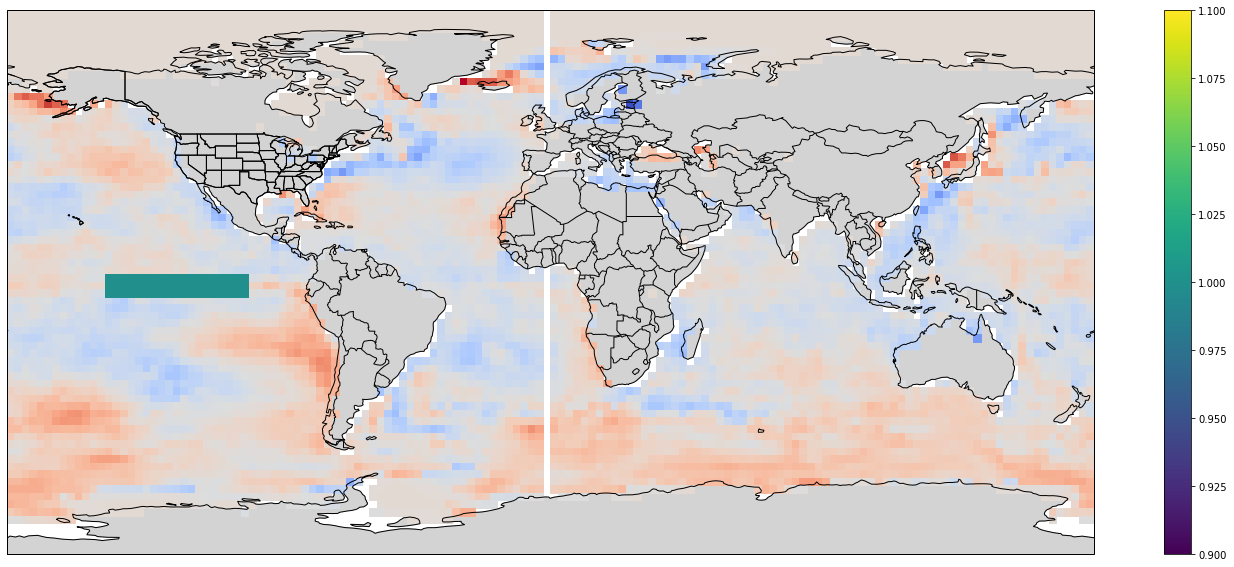

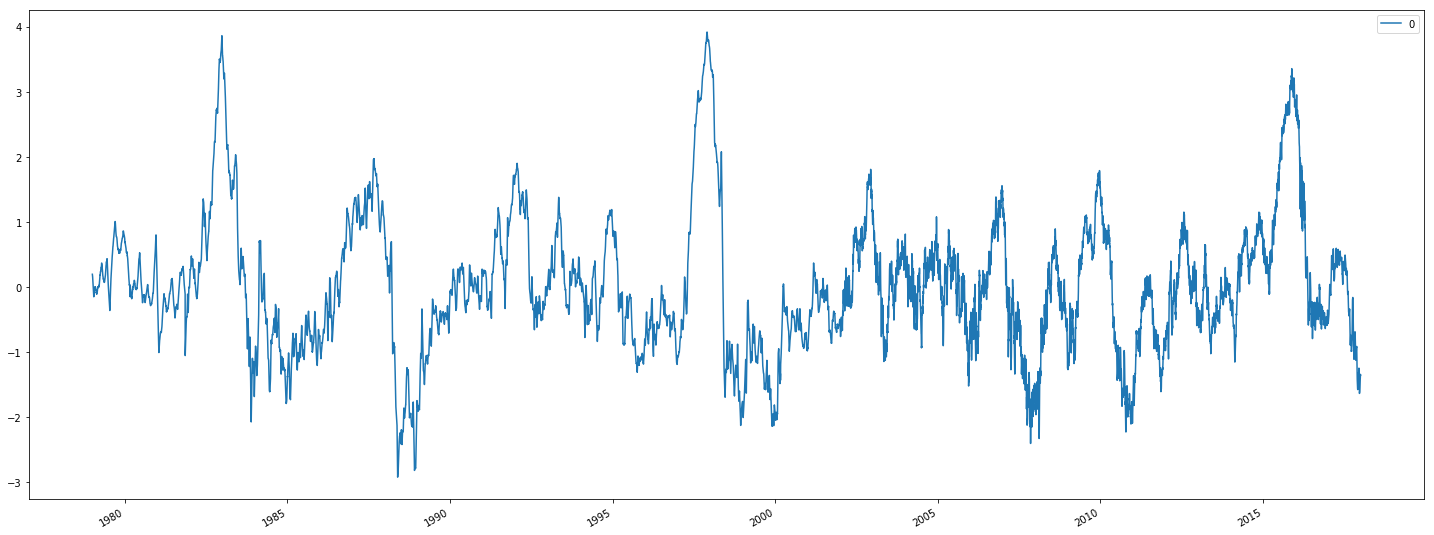

In [16]:
# Calculate ONI Region
ONI = (SST_GRID[..., 0] > 210) & (SST_GRID[..., 0] < 260) & (SST_GRID[..., 1] > -5) & (SST_GRID[..., 1] < 5)

# Calculate ONI Index
ONI_INDEX = pd.DataFrame(SST_anomaly[:, ONI].mean(1), index=TIME.index)

# Save ONI Index to Disk
ONI_INDEX.to_csv(os.path.join(DATA_ROOT, 'out', 'ONI.csv'))

# Plot ONI Region
ax, projection = plot_earth()
plt.pcolormesh(SST_LONGITUDE, SST_LATITUDE, SST_anomaly[0], cmap='coolwarm', transform=projection)
plt.pcolormesh(SST_LONGITUDE, SST_LATITUDE, mask_plot(ONI))
plt.colorbar()
plt.show()

# Plot ONI Index
ONI_INDEX.plot()
plt.show()